# Molecular Distance Geometry

## Basic Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
def dist(p, q):
    return np.linalg.norm(p - q)


def norm(v):
    return np.linalg.norm(v)

## Reading the input from a csv

In [3]:
# data = pd.read_csv("7_18.csv")
data = pd.read_csv("108_659.csv")

In [4]:
data

,u,v,duv
0,1,2,1.435772
1,1,3,2.436804
2,1,4,3.604732
3,1,5,4.854862
4,2,3,1.510743
...,...,...,...
654,105,107,2.416759
655,105,108,3.012541
656,106,107,1.541486
657,106,108,2.475582


## Converting the data to a graph

In [5]:
n = max(data['v']) # number of vertices in the graph
m = len(data['duv']) # number of edges in the graph

In [6]:
n, m

(108, 659)

In [7]:
g = [[] for _ in range(n + 1)]
edges = []
prune_edges = []

for i, r in data.iterrows():
    u = int(r['u'])
    v = int(r['v'])
    duv = r['duv']

    g[u].append((v, duv))
    g[v].append((u, duv))
    edges.append((u, v, duv))

    if u + 3 < v:
        prune_edges.append((u, v))

## Symetries

In [8]:
def sym(n, prune_edges):
    w = [0 for _ in range(n + 1)]

    for ep in prune_edges:
        u = ep[0]
        v = ep[1]

        w[u] = max(w[u], v)

    eps = []

    for i in range(n + 1):
        if w[i] != 0:
            eps.append((i, w[i]))

    u_bar, v_bar = eps[0]
    S_bar = []

    for k in range(1, len(eps)):
        u_k = eps[k][0]
        v_k = eps[k][1]

        if v_bar >= u_k + 3:
            v_bar = max(v_bar, v_k)
        else:
            S_bar.append((u_bar + 4, v_bar))
            u_bar = u_k
            v_bar = v_k

    S_bar.append((u_bar + 4, v_bar))

    S = [4]
    i = 0
    for v in range(5, n + 1):
        u_bar = S_bar[i][0]
        v_bar = S_bar[i][1]

        if not (u_bar <= v and v <= v_bar):
            S.append(v)

        if v == v_bar and i + 1 < len(S_bar):
            i += 1

    return np.array(S)

In [9]:
sym(n, prune_edges)

array([ 4, 40])

## Branch & Prune

In [10]:
def comprimento_aresta(g, u, v):
    duv = 0.0

    for i in range(len(g[u])):
        if g[u][i][0] == v:
            duv = g[u][i][1]
            break

    return duv


def pontos_iniciais(n, g):
    X = np.array([np.array([0.0, 0.0, 0.0]) for _ in range(n + 1)])

    d12 = comprimento_aresta(g, 1, 2)
    d13 = comprimento_aresta(g, 1, 3)
    d23 = comprimento_aresta(g, 2, 3)

    cth = (d12**2 + d23**2 - d13**2) / (2 * d12 * d23)
    th = np.arccos(cth)
    sth = np.sin(th)

    X[2] = np.array([-d12, 0.0, 0.0])
    X[3] = np.array([-d12 + d23 * cth, d23 * sth, 0.0])

    return X

In [11]:
def intersecao_3_esferas(A, ra, B, rb, C, rc):
    x1 = A
    x2 = B
    x3 = C
    # print("Intersecao3Esferas ", x1, x2, x3)
    d12 = dist(x1, x2)
    d13 = dist(x1, x3)
    d14 = ra
    d23 = dist(x2, x3)
    d24 = rb
    d34 = rc

    r = (x3 - x2) / d23
    k234 = (d24**2 + d23**2 - d34**2) / (2 * d23)
    p234 = np.sqrt(d24**2 - k234**2)

    v = x1 - x2
    k123 = (d12**2 + d23**2 - d13**2) / (2 * d23)
    p123 = np.sqrt(d12**2 - k123**2)

    alpha = ((k234 - k123)**2 + p234**2 + p123**2) / (2 * p234 * p123)
    beta = -(1 / (2 * p234 * p123))

    cw = alpha + beta * d14**2
    sw = np.sqrt(1 - cw**2)

    X1 = x2 + k234 * r + (p234 / p123) * (
        (v - k123 * r) * cw + np.cross(r, v) * sw)
    X2 = x2 + k234 * r + (p234 / p123) * (
        (v - k123 * r) * cw - np.cross(r, v) * sw)

    return np.array([X1, X2])

In [12]:
def calcula_ponto(g, X, b, k):
    d1 = comprimento_aresta(g, k - 3, k)
    d2 = comprimento_aresta(g, k - 2, k)
    d3 = comprimento_aresta(g, k - 1, k)
    # print("CalculaPonto ", X[k-3], d1, X[k-2], d2, X[k-1], d3)
    pp = intersecao_3_esferas(X[k - 3], d1, X[k - 2], d2, X[k - 1], d3)
    return pp[b]


def calcula_erro(g, X, v):
    erro = 0.0
    for i in range(len(g[v])):
        u = g[v][i][0]
        di = g[v][i][1]

        if u < v:
            duv = dist(X[u], X[v])
            erro += (duv**2 - di**2)**2

    return np.sqrt(erro)

In [13]:
def bp(n, g, onesol=False, delta=10**-6):
    X = pontos_iniciais(n, g)
    branch = np.zeros(n + 1, dtype=int)
    vist = np.zeros(n + 1, dtype=int)
    vist[1] = 1
    vist[2] = 1
    vist[3] = 1

    sol = {"X": [], "branch": []}

    k = 4

    while k > 3:
        vist[k] += 1
        X[k] = calcula_ponto(g, X, branch[k], k)
        erro = calcula_erro(g, X, k)

        prune = erro > delta

        if not prune and k == n:
            sol["X"].append(np.copy(X))
            sol["branch"].append(np.copy(branch))
            if onesol:
                return sol

        prune = prune or k == n

        if prune and branch[k] == 1:
            while k > 3 and branch[k] == 1:
                k -= 1

        if prune and branch[k] == 0:
            branch[k] = 1
            for i in range(k + 1, n + 1):
                branch[i] = 0

        if not prune:
            k += 1

    return sol

In [14]:
sol = bp(n, g)

## Sym BP

In [15]:
def reflexao_plano(x1, x2, x3, x):
    v1 = x1 - x2
    v2 = x3 - x2
    n = np.cross(v1, v2)
    n = n / norm(n)
    t = 2 * np.dot(n, x2 - x)
    return x + t * n


def troca_sinal(s, piv):
    x1 = s["X"][piv - 3]
    x2 = s["X"][piv - 2]
    x3 = s["X"][piv - 1]
    t = copy.deepcopy(s)

    for i in range(piv, len(t['X'])):
        t['X'][i] = reflexao_plano(x1, x2, x3, t['X'][i])
        t['branch'][i] = 1 - t['branch'][i]

    return t

In [16]:
def encontra_caminhos(sol, S):
    tree = [0 for _ in range(2**(len(S) + 1))]
    tree[1] = copy.deepcopy(sol)

    piv = 0
    k = 0
    # print("tree[1]:", tree[1] )
    for i in range(1, 2**len(S)):
        if 2**k == i:
            piv = S[k]
            k += 1
        tree[2 * i] = copy.deepcopy(tree[i])
        tree[2 * i + 1] = copy.deepcopy(troca_sinal(tree[i], piv))

    return tree[2**len(S):2**(len(S) + 1)]

In [17]:
def symbp(n, g, prune_edges):
    sol = bp(n, g, True)
    S = sym(n, prune_edges)
    first_sol = {"X": sol["X"][0], "branch": sol["branch"][0]}
    sol = {"X": [], "branch": []}
    ans = encontra_caminhos(first_sol, S)

    for a in ans:
        sol["X"].append(a["X"])
        sol["branch"].append(a["branch"])

    return sol

In [18]:
sol = symbp(n, g, prune_edges)

## Split BP

In [19]:
def split_instance(n, g, S):
    S = np.append(S, [n + 1])

    h = []

    for i in range(1, len(S)):
        u = S[i - 1] - 3
        v = S[i]

        it = {
            "n": v - u,
            "m": 0,
            "edges": [],
            "g": [[] for _ in range(v - u + 1)]
        }

        for j in range(u, v):
            for k, d in g[j]:
                if j < k and k < v:
                    it["edges"].append((j - u + 1, k - u + 1, d))
                    it["g"][j - u + 1].append((k - u + 1, d))
                    it["g"][k - u + 1].append((j - u + 1, d))
                    it["m"] += 1

        h.append(it)

    return h

In [20]:
def encontra_solucao(n, g, prune_edges, S):
    h = split_instance(n, g, S.copy())

    branch = [0, 0, 0, 0]

    for it in h:
        sol = bp(it['n'], it['g'], True)
        bb = sol["branch"][0][4:it['n'] + 1]
        for b in bb:
            branch.append(b)
    branch = np.array(branch)

    X = pontos_iniciais(n, g)
    for k in range(4, n + 1):
        X[k] = calcula_ponto(g, X, branch[k], k)

    return {"X": [X], "branch": [branch]}


def splitbp(n, g, prune_edges):
    S = sym(n, prune_edges)
    sol = encontra_solucao(n, g, prune_edges, S)
    first_sol = {"X": sol["X"][0], "branch": sol["branch"][0]}
    sol = {"X": [], "branch": []}
    ans = encontra_caminhos(first_sol, S)

    for a in ans:
        sol["X"].append(a["X"])
        sol["branch"].append(a["branch"])

    return sol

In [21]:
sol = splitbp(n, g, prune_edges)

## Show the solution

In [22]:
def show_solution(X, branch):
    n = len(branch)
    print(branch)
    print(X[1:])
    ax = plt.figure().gca(projection="3d")
    ax.plot(X[3:, 0], X[3:, 1], X[3:, 2], 'o-')
    ax.plot(X[1:4, 0], X[1:4, 1], X[1:4, 2], 'ro-')
    plt.draw()
    plt.show()
    print()

[0 0 0 0 0 1 0 1 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 0 1 1 1 1 0 0 0 0 1 1 0
 1 0 0 0 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 0 1 1 0 0 1]
[[  0.           0.           0.        ]
 [ -1.43577192   0.           0.        ]
 [ -1.99095341   1.40503292   0.        ]
 [ -3.23057858   1.57482328  -0.27818462]
 [ -3.84600502   2.93737686  -0.38697365]
 [ -3.2095446    3.65805538  -1.55066158]
 [ -3.14990699   4.99164527  -1.27963138]
 [ -2.63837379   5.86190798  -2.35938626]
 [ -3.73063572   6.05689729  -3.45611232]
 [ -3.24214378   6.36747341  -4.62914647]
 [ -4.15515997   6.37258668  -5.82464021]
 [ -5.20497853   7.46937106  -5.66616303]
 [ -6.45407316   7.16846123  -5.87956608]
 [ -7.47638386   8.13300946  -5.65164166]
 [ -7.39421831   9.29441057  -6.70760865]
 [ -7.82791811  10.39479752  -6.21750863]
 [ -7.99091824  11.64531438  -7.07048258]
 [ -9.28725018  11.56229318  -7.85417255]
 [ -9.22992352  11.638

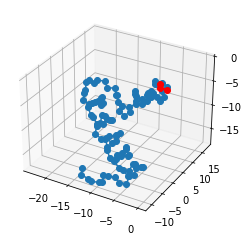


[0 0 0 0 0 1 0 1 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 0 1 1 1 1 0 0 0 0 1 1 0
 1 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 0 1 0 0 1 1 0]
[[  0.           0.           0.        ]
 [ -1.43577192   0.           0.        ]
 [ -1.99095341   1.40503292   0.        ]
 [ -3.23057858   1.57482328  -0.27818462]
 [ -3.84600502   2.93737686  -0.38697365]
 [ -3.2095446    3.65805538  -1.55066158]
 [ -3.14990699   4.99164527  -1.27963138]
 [ -2.63837379   5.86190798  -2.35938626]
 [ -3.73063572   6.05689729  -3.45611232]
 [ -3.24214378   6.36747341  -4.62914647]
 [ -4.15515997   6.37258668  -5.82464021]
 [ -5.20497853   7.46937106  -5.66616303]
 [ -6.45407316   7.16846123  -5.87956608]
 [ -7.47638386   8.13300946  -5.65164166]
 [ -7.39421831   9.29441057  -6.70760865]
 [ -7.82791811  10.39479752  -6.21750863]
 [ -7.99091824  11.64531438  -7.07048258]
 [ -9.28725018  11.56229318  -7.85417255]
 [ -9.22992352  11.63

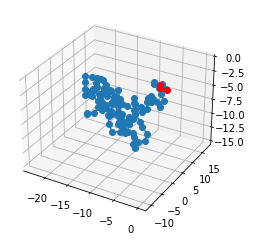


[0 0 0 0 1 0 1 0 0 1 0 1 1 0 1 1 0 0 1 0 0 1 0 1 1 1 0 0 0 0 1 1 1 1 0 0 1
 0 1 1 1 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 1 1 1 0 0 1 0 0 1 1 0]
[[  0.           0.           0.        ]
 [ -1.43577192   0.           0.        ]
 [ -1.99095341   1.40503292   0.        ]
 [ -3.23057858   1.57482328   0.27818462]
 [ -3.84600502   2.93737686   0.38697365]
 [ -3.2095446    3.65805538   1.55066158]
 [ -3.14990699   4.99164527   1.27963138]
 [ -2.63837379   5.86190798   2.35938626]
 [ -3.73063572   6.05689729   3.45611232]
 [ -3.24214378   6.36747341   4.62914647]
 [ -4.15515997   6.37258668   5.82464021]
 [ -5.20497853   7.46937106   5.66616303]
 [ -6.45407316   7.16846123   5.87956608]
 [ -7.47638386   8.13300946   5.65164166]
 [ -7.39421831   9.29441057   6.70760865]
 [ -7.82791811  10.39479752   6.21750863]
 [ -7.99091824  11.64531438   7.07048258]
 [ -9.28725018  11.56229318   7.85417255]
 [ -9.22992352  11.63

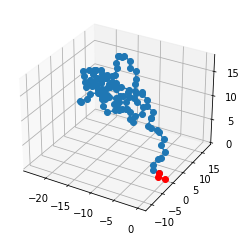


[0 0 0 0 1 0 1 0 0 1 0 1 1 0 1 1 0 0 1 0 0 1 0 1 1 1 0 0 0 0 1 1 1 1 0 0 1
 0 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 0 1 1 0 0 1]
[[  0.           0.           0.        ]
 [ -1.43577192   0.           0.        ]
 [ -1.99095341   1.40503292   0.        ]
 [ -3.23057858   1.57482328   0.27818462]
 [ -3.84600502   2.93737686   0.38697365]
 [ -3.2095446    3.65805538   1.55066158]
 [ -3.14990699   4.99164527   1.27963138]
 [ -2.63837379   5.86190798   2.35938626]
 [ -3.73063572   6.05689729   3.45611232]
 [ -3.24214378   6.36747341   4.62914647]
 [ -4.15515997   6.37258668   5.82464021]
 [ -5.20497853   7.46937106   5.66616303]
 [ -6.45407316   7.16846123   5.87956608]
 [ -7.47638386   8.13300946   5.65164166]
 [ -7.39421831   9.29441057   6.70760865]
 [ -7.82791811  10.39479752   6.21750863]
 [ -7.99091824  11.64531438   7.07048258]
 [ -9.28725018  11.56229318   7.85417255]
 [ -9.22992352  11.63

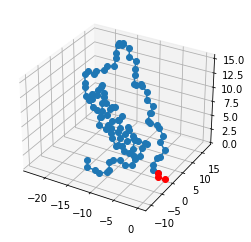

In [23]:
for X, branch in zip(sol['X'], sol['branch']):
    show_solution(X, branch)